In [6]:
import pandas as pd
import pickle
import dask.dataframe as dd


df = dd.read_csv("../Dataset1/*").compute()

# df = pd.read_csv("/content/drive/My Drive/Year4Project/*")

X = df.iloc[:,:400]
Y = df.iloc[:,400:]



In [27]:
df['label_1'].nunique(), df['label_2'].nunique(), df['label_3'].nunique()

(10000, 10000, 10000)

In [28]:
X.dtypes.unique()

array([dtype('float64')], dtype=object)

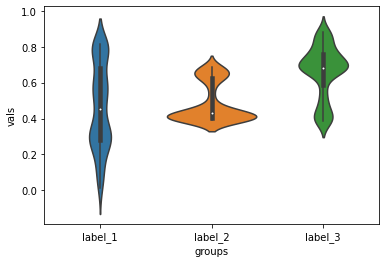

In [29]:
import seaborn as sns

sns.violinplot(x = 'groups', y='vals', data = df.corr().abs()[['label_1', 'label_2', 'label_3']].iloc[:400].melt(var_name='groups', value_name='vals'))


In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.5, random_state = 42)

In [32]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import numpy as np


rf_params = {
    'estimator__n_estimators' : [int(i) for i in np.logspace(1,2,4)],
    'estimator__max_depth' :  range(8,20,2)
}
regr_multi_rf = MultiOutputRegressor(RandomForestRegressor())
rf_gs = GridSearchCV(regr_multi_rf, rf_params, cv=2, verbose=5)

rf_gs.fit(x_train, y_train)
print('Random Forest Training Error is {0:.5g}'.format(mean_squared_error(rf_gs.predict(x_train), y_train)))
print('Random Forest Validation Error is {0:.5g}'.format(mean_squared_error(rf_gs.predict(x_val), y_val)))

svr_params = {
    'estimator__C': np.logspace(-1,2.5,5),
    'estimator__epsilon': np.logspace(-2,3,5),
            }

regr_multi_svr = MultiOutputRegressor(SVR(gamma = 0.01))
svr_gs = GridSearchCV(regr_multi_svr, svr_params, cv=2, verbose=5)

svr_gs.fit(x_train, y_train)

pickle.dump(svr_gs, open('../Models/SVR42.pkl', 'wb'))

pickle.dump(rf_gs, open('../Models/RF42.pkl', 'wb'))

print('SVR Training Error is {0:.5g}'.format(mean_squared_error(svr_gs.predict(x_train), y_train)))
print('SVR Validation Error is {0:.5g}'.format(mean_squared_error(svr_gs.predict(x_val), y_val)))

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] estimator__max_depth=8, estimator__n_estimators=10 ..............
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  estimator__max_depth=8, estimator__n_estimators=10, score=0.958, total=   4.1s
[CV] estimator__max_depth=8, estimator__n_estimators=10 ..............
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s
[CV]  estimator__max_depth=8, estimator__n_estimators=10, score=0.959, total=   4.3s
[CV] estimator__max_depth=8, estimator__n_estimators=21 ..............
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


KeyboardInterrupt: 

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD, Adam

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, ˙patience=50, verbose=1,)
opt = Adam()

model = Sequential()
model.add(Dense(300, input_dim=400, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(75, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal',))
# Compile model
model.compile(loss='mean_squared_error', optimizer=opt,)
model.summary()

ModuleNotFoundError: No module named 'keras'

In [14]:
import matplotlib.pyplot as plt

history = model.fit(x=x_train, y=y_train, validation_data = (x_val, y_val), epochs=1000, verbose=1, callbacks=[reduce_lr])



NameError: name 'model' is not defined

In [15]:
# Plot training & validation accuracy values
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('../Models/NN42LossCurve.png')
plt.show()

NameError: name 'history' is not defined

In [16]:

model.save('../Models/NN42.h5')



NameError: name 'model' is not defined

In [34]:
from keras.models import load_model
import pickle

model = load_model('../Models/NN42.h5')

svr_gs = pickle.load(open('../Models/SVR42.pkl', 'rb'))

rf_gs = pickle.load(open('../Models/RF42.pkl', 'rb'))

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [35]:
from sklearn.metrics import max_error, mean_squared_error
import time

start = time.time()
print('Random Forest Test Error is {0:.5g}'.format(mean_squared_error(rf_gs.predict(x_test), y_test)))
end = time.time()
print('And took {0:.3g} seconds to evaluate the test dataset'.format(end-start))

start = time.time()
print('SVR Test Error is {0:.5g}'.format(mean_squared_error(svr_gs.predict(x_test), y_test)))
end = time.time()
print('And took {0:.3g} seconds to evaluate the test dataset'.format(end-start))

start = time.time()
print('NN Test Error is {0:.5g}'.format(mean_squared_error(model.predict(x_test), y_test)))
end = time.time()
print('And took {0:.3g} seconds to evaluate the test dataset'.format(end-start))


Random Forest Test Error is 0.0014139
And took 0.44 seconds to evaluate the test dataset
SVR Test Error is 0.00070815
And took 8.99 seconds to evaluate the test dataset
NN Test Error is 4.174e-06
And took 0.179 seconds to evaluate the test dataset


In [36]:
data = [y_test.values, rf_gs.predict(x_test), svr_gs.predict(x_test), model.predict(x_test)]

In [38]:
import numpy as np

columns = ['exact_1', 'exact_2', 'exact_3', 'rf_1', 'rf_2', 'rf_3', 'svr_1', 'svr_2', 'svr_3', 'nn_1', 'nn_2', 'nn_3']
df1 = pd.concat([pd.DataFrame(i) for i in data], axis=1)
df1.columns = columns

df1['rf_1_err'] = (df1['rf_1'] - df1['exact_1']).abs()
df1['rf_2_err'] = (df1['rf_2'] - df1['exact_2']).abs()
df1['rf_3_err'] = (df1['rf_3'] - df1['exact_3']).abs()

df1['svr_1_err'] = (df1['svr_1'] - df1['exact_1']).abs()
df1['svr_2_err'] = (df1['svr_2'] - df1['exact_2']).abs()
df1['svr_3_err'] = (df1['svr_3'] - df1['exact_3']).abs()

df1['nn_1_err'] = (df1['nn_1'] - df1['exact_1']).abs()
df1['nn_2_err'] = (df1['nn_2'] - df1['exact_2']).abs()
df1['nn_3_err'] = (df1['nn_3'] - df1['exact_3']).abs()


df1['rf_err2'] = np.linalg.norm(df1[['rf_1', 'rf_2', 'rf_3']].values - df1[['exact_1', 'exact_2', 'exact_3']].values, axis=1)
df1['svr_err2'] = np.linalg.norm(df1[['svr_1', 'svr_2', 'svr_3']].values - df1[['exact_1', 'exact_2', 'exact_3']].values, axis=1)
df1['nn_err2'] = np.linalg.norm(df1[['nn_1', 'nn_2', 'nn_3']].values - df1[['exact_1', 'exact_2', 'exact_3']].values, axis=1)

df1['rf_errinf'] = np.linalg.norm(df1[['rf_1', 'rf_2', 'rf_3']].values - df1[['exact_1', 'exact_2', 'exact_3']].values, axis=1, ord=np.inf)
df1['svr_errinf'] = np.linalg.norm(df1[['svr_1', 'svr_2', 'svr_3']].values - df1[['exact_1', 'exact_2', 'exact_3']].values, axis=1, ord=np.inf)
df1['nn_errinf'] = np.linalg.norm(df1[['nn_1', 'nn_2', 'nn_3']].values - df1[['exact_1', 'exact_2', 'exact_3']].values, axis=1, ord=np.inf)


df1.to_csv('../Models/ML_results.csv')
df1.describe()


,exact_1,exact_2,exact_3,rf_1,rf_2,rf_3,svr_1,svr_2,svr_3,nn_1,...,svr_3_err,nn_1_err,nn_2_err,nn_3_err,rf_err2,svr_err2,nn_err2,rf_errinf,svr_errinf,nn_errinf
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.498782,1.502443,1.498650,1.498366,1.505372,1.495790,1.497767,1.502512,1.499788,1.498419,...,0.015634,1.273716e-03,1.555433e-03,1.680156e-03,0.050254,0.027211,0.003019,0.042725,0.021007,0.002524
std,0.286616,0.289209,0.287955,0.283318,0.272887,0.276554,0.278307,0.280772,0.277957,0.286740,...,0.023841,1.067966e-03,1.409739e-03,1.590805e-03,0.041430,0.037206,0.001845,0.035016,0.027561,0.001614
min,1.000039,1.000378,1.001291,1.011226,1.022251,1.016337,0.995354,0.992564,1.004736,0.997822,...,0.000003,4.590552e-07,2.532185e-07,1.578303e-07,0.001916,0.000805,0.000180,0.001253,0.000626,0.000153
25%,1.253317,1.258074,1.253138,1.251015,1.263701,1.252039,1.261070,1.261428,1.257378,1.252836,...,0.004327,4.771545e-04,5.515809e-04,6.197132e-04,0.022817,0.010774,0.001829,0.019002,0.008541,0.001505
50%,1.497411,1.499383,1.493989,1.500206,1.504226,1.493437,1.505451,1.496968,1.492695,1.496590,...,0.008769,9.907327e-04,1.215740e-03,1.326143e-03,0.038561,0.015510,0.002693,0.033026,0.011958,0.002234
75%,1.745962,1.748390,1.748747,1.745447,1.746445,1.742725,1.735227,1.748177,1.742072,1.746170,...,0.016339,1.790560e-03,2.128239e-03,2.328812e-03,0.063663,0.027495,0.003811,0.054448,0.021274,0.003196
max,1.999929,1.999924,1.999743,1.987880,1.967463,1.988544,2.018205,2.000475,1.991462,2.007056,...,0.334100,8.717820e-03,1.506632e-02,3.182017e-02,0.423051,0.537710,0.034821,0.349506,0.385641,0.031820


In [39]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from numpy import sin, cos, pi
from plotly.subplots import make_subplots
from decimal import *
import numpy as np


# some math: generate points on the surface of ellipsoid

index = np.random.randint(0,5000)

phi = np.linspace(0, 2*pi, )
theta = np.linspace(-pi/2, pi/2, )
phi, theta=np.meshgrid(phi, theta)

x_exact = cos(theta) * sin(phi) * df1['exact_1'][index]
y_exact = cos(theta) * cos(phi) * df1['exact_2'][index]
z_exact = sin(theta) * df1['exact_3'][index]

x_rf = cos(theta) * sin(phi) * df1['rf_1'][index]
y_rf = cos(theta) * cos(phi) * df1['rf_2'][index]
z_rf = sin(theta) * df1['rf_3'][index]

x_svr = cos(theta) * sin(phi) * df1['svr_1'][index]
y_svr = cos(theta) * cos(phi) * df1['svr_2'][index]
z_svr = sin(theta) * df1['svr_3'][index]

x_nn = cos(theta) * sin(phi) * df1['nn_1'][index]
y_nn = cos(theta) * cos(phi) * df1['nn_2'][index]
z_nn = sin(theta) * df1['nn_3'][index]

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=("Random Forest ({0:.3E})".format(Decimal(df1['rf_err2'][index]**2)), "SVR ({0:.3E})".format(Decimal(df1['svr_err2'][index]**2)), "Neural Network ({0:.3E})".format(Decimal(df1['nn_err2'][index]**2))))

exact = go.Mesh3d({     
    'x': x_exact.flatten(), 
    'y': y_exact.flatten(), 
    'z': z_exact.flatten(),
    'color':'green',
    'alphahull': 0,
    'opacity':0.3,
    'name':'exact'
})

# fig.add_trace(exact, row=1, col=1)
# fig.add_trace(exact, row=1, col=2)
# fig.add_trace(exact, row=1, col=3)

svr_intensity = np.log(((x_exact.flatten()-x_svr.flatten())**2+ (y_exact.flatten()-y_svr.flatten())**2 + (z_exact.flatten()-z_svr.flatten())**2)**0.5)

svr = go.Mesh3d({     
    'x': x_svr.flatten(), 
    'y': y_svr.flatten(), 
    'z': z_svr.flatten(), 
    'alphahull': 0,
    'name':'svr',
    'opacity':0.5,
    'coloraxis' : "coloraxis",
    'hovertext':svr_intensity,
    'hoverinfo':'name + text',
    'intensity' : svr_intensity,
})

fig.add_trace(svr, row=1, col=2)

rf_intensity = np.log(((x_exact.flatten()-x_rf.flatten())**2+ (y_exact.flatten()-y_rf.flatten())**2 + (z_exact.flatten()-z_rf.flatten())**2)**0.5)

rf = go.Mesh3d({     
    'x': x_rf.flatten(), 
    'y': y_rf.flatten(), 
    'z': z_rf.flatten(), 
    'alphahull': 0,
    'name':'rf',
    'intensity' : rf_intensity,
    'opacity':0.5,
    'coloraxis' : "coloraxis",
    'hovertext': rf_intensity,
    'hoverinfo':'name + text'
})

fig.add_trace(rf, row=1, col=1)

nn_intensity = np.log(((x_exact.flatten()-x_nn.flatten())**2+ (y_exact.flatten()-y_nn.flatten())**2 + (z_exact.flatten()-z_nn.flatten())**2)**0.5)

nn = go.Mesh3d({     
    'x': x_nn.flatten(), 
    'y': y_nn.flatten(), 
    'z': z_nn.flatten(), 
    'alphahull': 0,
    'intensity' : nn_intensity,
    'name':'nn',
    'opacity':0.5,
    'coloraxis' : "coloraxis",
    'hovertext':nn_intensity,
    'hoverinfo':'name + text'
})

fig.update_layout(coloraxis = {'colorscale':'Magma'})

fig.update_layout(title_text="Object %d" % index)
                  
fig.add_trace(nn, row=1, col=3)

iplot(fig)

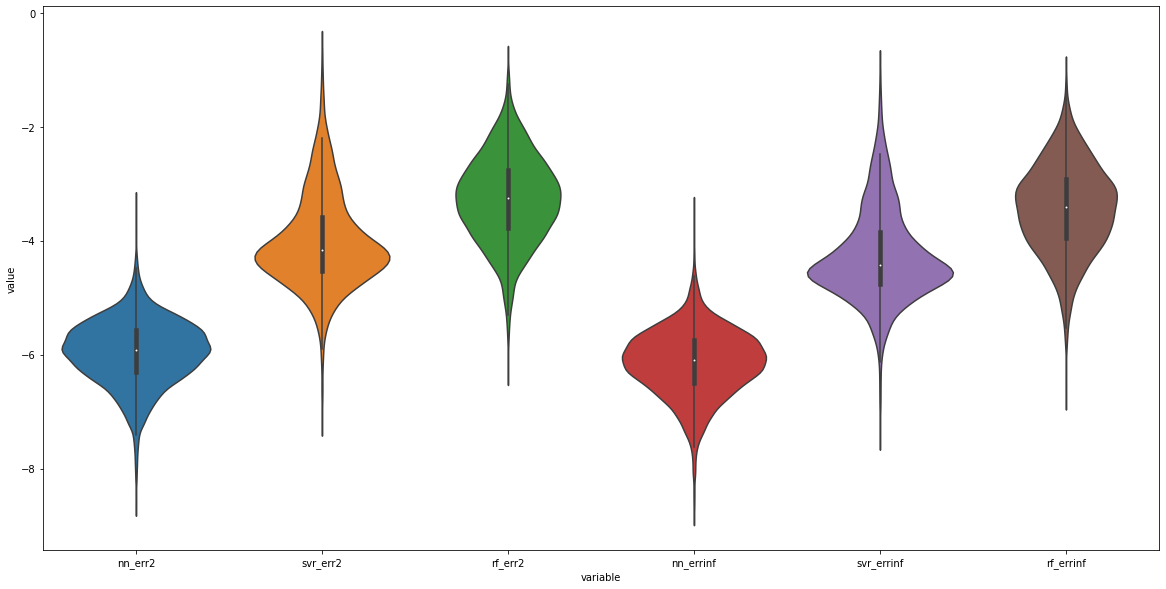

In [40]:
plt.figure(figsize=(20, 10))

sns.violinplot(x='variable', y='value', data=df1[['nn_err2', 'svr_err2', 'rf_err2','nn_errinf', 'svr_errinf', 'rf_errinf']].apply(lambda x: np.log(x)).melt())

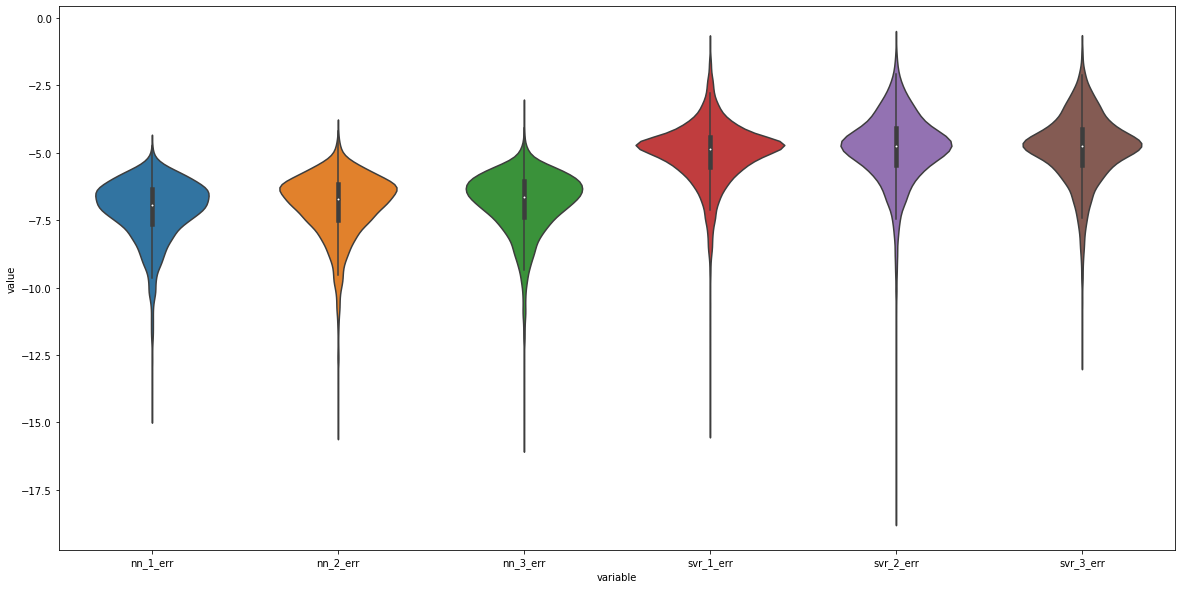

In [41]:
plt.figure(figsize=(20, 10))

sns.violinplot(x='variable', y='value', data=df1[['nn_1_err', 'nn_2_err', 'nn_3_err', 'svr_1_err', 'svr_2_err', 'svr_3_err']].apply(lambda x: np.log(x)).melt());

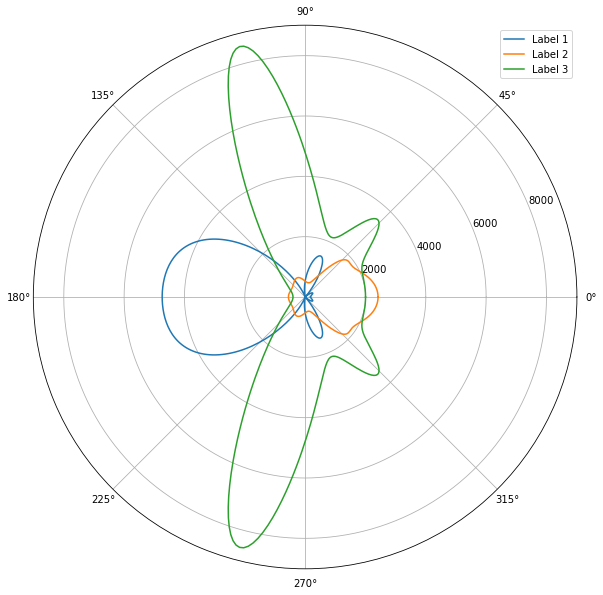

In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#The F-Score is calculated using the variance 
#between the features and the variance within each feature.'

plt.figure(figsize=(10, 10))

selector = SelectKBest(f_regression, k=10)
selector.fit_transform(x_train, y_train['label_1'])
label1_f = selector.scores_

selector.fit_transform(x_train, y_train['label_2'])
label2_f = selector.scores_

selector.fit_transform(x_train, y_train['label_3'])
label3_f = selector.scores_

plt.polar(np.linspace(0,2*np.pi, 400), label1_f, label='Label 1')
plt.polar(np.linspace(0,2*np.pi, 400), label2_f, label='Label 2')
plt.polar(np.linspace(0,2*np.pi, 400), label3_f, label='Label 3')
plt.legend()
plt.show()

In [48]:
print("Neural Network Performs best on {} points of the dataset".format(df1[(df1['nn_err2']<df1['svr_err2'])&(df1['nn_err2']<df1['rf_err2'])].shape[0]))

print("SVR outperforms Random Forest on {} points of the dataset".format(df1[df1['svr_err2']<df1['rf_err2']].shape[0]))

Neural Network Performs best on 4934 points of the dataset
SVR outperforms Random Forest on 4089 points of the dataset
